In [118]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch 
from torch import nn

n_samples = 1000

X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [119]:
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1], 
                        "lable": y})
circles

,X1,X2,lable
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
...,...,...,...
995,0.244054,0.944125,0
996,-0.978655,-0.272373,0
997,-0.136900,-0.810012,1
998,0.670362,-0.767502,0


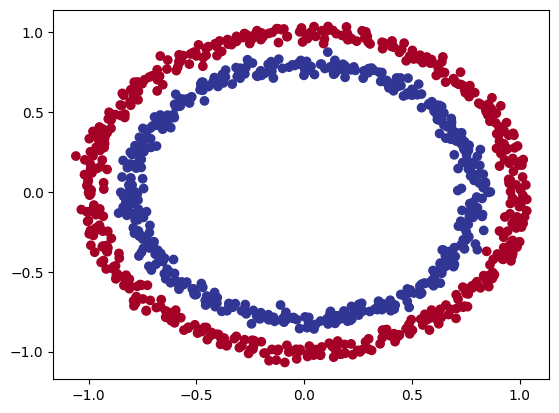

In [120]:
fig, ax = plt.subplots()
ax.scatter(x=X[:, 0],
           y=X[:, 1],
           c=y,
           cmap=plt.cm.RdYlBu)


In [121]:
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [124]:
class CicleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_0 = CicleModelV0().to(device=device)

In [125]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.3091],
  

In [126]:
with torch.inference_mode(): 
    untrained_preds = model_0(X_test.to(device))
    untrained_preds.shape

In [127]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [128]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred). sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [129]:
model_0.eval
with torch.inference_mode():
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_labels[:10].squeeze()

tensor([0., 0., 0., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')

In [130]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits,
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69509, Acc: 49.62 | Test loss: 0.696719, Test acc: 53.00
Epoch: 10 | Loss: 0.69491, Acc: 49.75 | Test loss: 0.696580, Test acc: 53.00
Epoch: 20 | Loss: 0.69476, Acc: 49.62 | Test loss: 0.696456, Test acc: 52.50
Epoch: 30 | Loss: 0.69462, Acc: 49.62 | Test loss: 0.696346, Test acc: 51.50
Epoch: 40 | Loss: 0.69449, Acc: 49.62 | Test loss: 0.696246, Test acc: 51.00
Epoch: 50 | Loss: 0.69438, Acc: 49.50 | Test loss: 0.696156, Test acc: 51.00
Epoch: 60 | Loss: 0.69428, Acc: 49.50 | Test loss: 0.696074, Test acc: 51.00
Epoch: 70 | Loss: 0.69418, Acc: 49.62 | Test loss: 0.696000, Test acc: 51.00
Epoch: 80 | Loss: 0.69410, Acc: 49.88 | Test loss: 0.695932, Test acc: 50.50
Epoch: 90 | Loss: 0.69402, Acc: 49.75 | Test loss: 0.695869, Test acc: 49.50
Epoch: 100 | Loss: 0.69395, Acc: 49.75 | Test loss: 0.695811, Test acc: 50.00
Epoch: 110 | Loss: 0.69388, Acc: 49.50 | Test loss: 0.695758, Test acc: 50.00
Epoch: 120 | Loss: 0.69382, Acc: 49.75 | Test loss: 0.695708, Test acc: 49.

In [131]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else: 
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


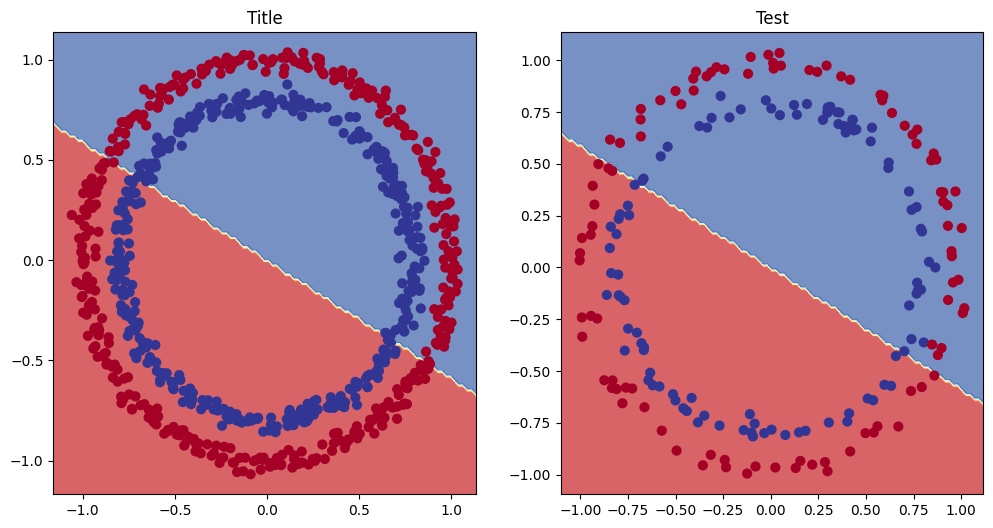

In [132]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Title")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [134]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=8)
        self.layer_3 = nn.Linear(in_features=8, out_features=1)
    
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    


In [143]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]], device='cuda:0')

In [154]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = CircleModelV1().to(device)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()

    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:5f}, Test acc: {test_acc:.2f}")





Epoch: 0 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 100 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 200 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 300 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 400 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 500 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 600 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 700 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 800 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
Epoch: 900 | Loss: 0.69963, Acc: 50.00 | Test loss: 0.694829, Test acc: 50.00
